In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import tensorflow as tf


=== Logistic Regression (SGD, eta0=0.7) with Polynomial Features on Dataset 3 ===

--- Degree 5 ---
Train Confusion Matrix (rows=true, cols=pred) [0,1]:
[[566   6]
 [ 16 535]]
Train Accuracy: 0.9804
Test  Confusion Matrix (rows=true, cols=pred) [0,1]:
[[76  2]
 [ 6 76]]
Test  Accuracy: 0.9500


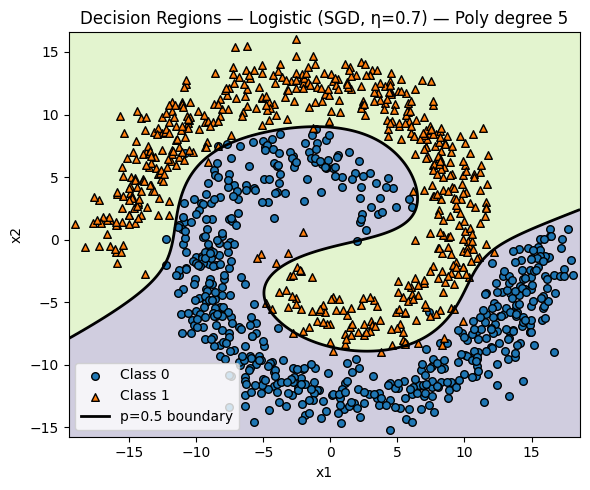


--- Degree 7 ---
Train Confusion Matrix (rows=true, cols=pred) [0,1]:
[[566   6]
 [ 20 531]]
Train Accuracy: 0.9768
Test  Confusion Matrix (rows=true, cols=pred) [0,1]:
[[77  1]
 [ 6 76]]
Test  Accuracy: 0.9563


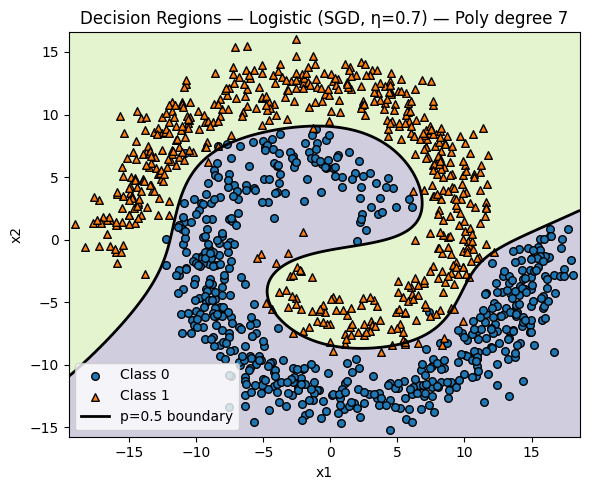


--- Degree 9 ---
Train Confusion Matrix (rows=true, cols=pred) [0,1]:
[[568   4]
 [ 22 529]]
Train Accuracy: 0.9768
Test  Confusion Matrix (rows=true, cols=pred) [0,1]:
[[77  1]
 [ 6 76]]
Test  Accuracy: 0.9563


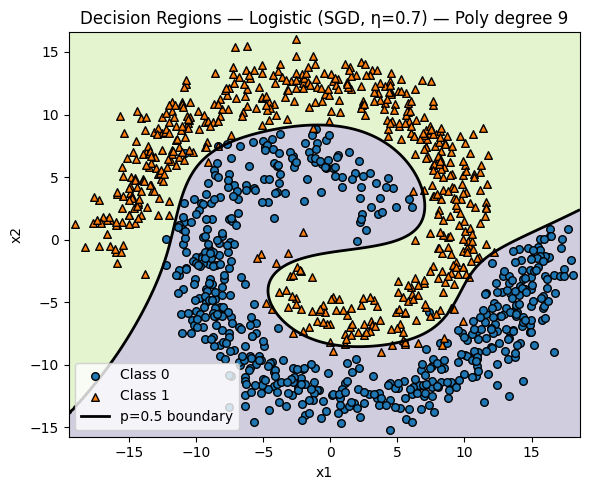

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

# ======== CONFIG: your CSV paths (from your message) ========
CSV_TRAIN = r"H:\Sem-7\CS5691\Assignment-3\Datasets\Dataset3\train.csv"
CSV_TEST  = r"H:\Sem-7\CS5691\Assignment-3\Datasets\Dataset3\test.csv"
DEGREES   = [5, 7, 9]
RANDOM_STATE = 42
LR = 0.7          # learning rate (eta0)
TOL = 1e-3        # convergence threshold
MAX_ITER = 100000
# ============================================================

# 1) Load data (train & test) — last column is the label {0,1}
df_tr = pd.read_csv(CSV_TRAIN)
df_te = pd.read_csv(CSV_TEST)

X_train = df_tr.iloc[:, :-1].to_numpy(dtype=float)
y_train = df_tr.iloc[:, -1].to_numpy(dtype=int)

X_test = df_te.iloc[:, :-1].to_numpy(dtype=float)
y_test = df_te.iloc[:, -1].to_numpy(dtype=int)

feature_names = list(df_tr.columns[:-1])

def make_pipeline(deg: int) -> Pipeline:
    return Pipeline([
        ("poly",   PolynomialFeatures(degree=deg, include_bias=False)),
        ("scaler", StandardScaler()),
        ("clf",    SGDClassifier(
            loss="log_loss",
            learning_rate="constant",
            eta0=LR,                # <-- learning rate here
            penalty="l2",
            alpha=0.0,              # no L2 unless you change it
            max_iter=MAX_ITER,
            tol=TOL,
            shuffle=True,
            random_state=RANDOM_STATE
        ))
    ])

def evaluate_split(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    acc = accuracy_score(y_true, y_pred)
    print(f"{name} Confusion Matrix (rows=true, cols=pred) [0,1]:\n{cm}")
    print(f"{name} Accuracy: {acc:.4f}")
    return cm, acc



def plot_decision_region_2d(pipe: Pipeline, X_tr_raw: np.ndarray, y_tr: np.ndarray, deg: int):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    d = X_tr_raw.shape[1]
    X2 = X_tr_raw[:, :2] if d >= 2 else np.c_[X_tr_raw[:, 0], np.zeros_like(X_tr_raw[:, 0])]

    x_min, x_max = X2[:, 0].min() - 0.5, X2[:, 0].max() + 0.5
    y_min, y_max = X2[:, 1].min() - 0.5, X2[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )

    # Build full feature grid: first two vary; others fixed at training means
    base = np.tile(X_tr_raw.mean(axis=0), (xx.size, 1))
    base[:, 0] = xx.ravel()
    if d >= 2:
        base[:, 1] = yy.ravel()

    # Predict on grid using the pipeline
    Z_labels = pipe.predict(base).reshape(xx.shape)
    Z_prob   = pipe.predict_proba(base)[:, 1].reshape(xx.shape)

    # Plot regions
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z_labels, alpha=0.25, levels=2)

    # Decision boundary (p=0.5)
    cs = plt.contour(xx, yy, Z_prob, levels=[0.5], linewidths=2, colors='k')

    # Overlay training points
    plt.scatter(X2[y_tr == 0, 0], X2[y_tr == 0, 1], s=30, edgecolor='k', marker='o', label='Class 0')
    plt.scatter(X2[y_tr == 1, 0], X2[y_tr == 1, 1], s=30, edgecolor='k', marker='^', label='Class 1')

    # Robust legend: add a proxy handle for the boundary
    boundary_handle = Line2D([0], [0], linestyle='-', linewidth=2, color='k', label='p=0.5 boundary')
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(boundary_handle)
    labels.append('p=0.5 boundary')
    plt.legend(handles, labels, loc='best')

    plt.xlabel(feature_names[0] if len(feature_names) >= 1 else "x1")
    plt.ylabel(feature_names[1] if len(feature_names) >= 2 else "x2")
    plt.title(f"Decision Regions — Logistic (SGD, η=0.7) — Poly degree {deg}")
    plt.tight_layout()
    plt.show()


print("\n=== Logistic Regression (SGD, eta0=0.7) with Polynomial Features on Dataset 3 ===")
for deg in DEGREES:
    print(f"\n--- Degree {deg} ---")
    pipe = make_pipeline(deg)
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred_train = pipe.predict(X_train)
    y_pred_test  = pipe.predict(X_test)

    # Metrics
    cm_tr, acc_tr = evaluate_split("Train", y_train, y_pred_train)
    cm_te, acc_te = evaluate_split("Test ", y_test,  y_pred_test)

    # Decision region with training data superposed
    plot_decision_region_2d(pipe, X_train, y_train, deg)


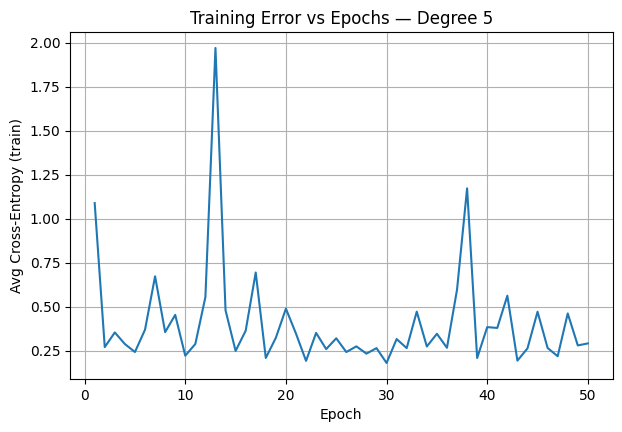


Degree 5 — Train Confusion Matrix:
[[568   4]
 [ 19 532]]
Train Accuracy: 97.95%

Degree 5 — Test Confusion Matrix:
[[77  1]
 [ 6 76]]
Test Accuracy: 95.62%


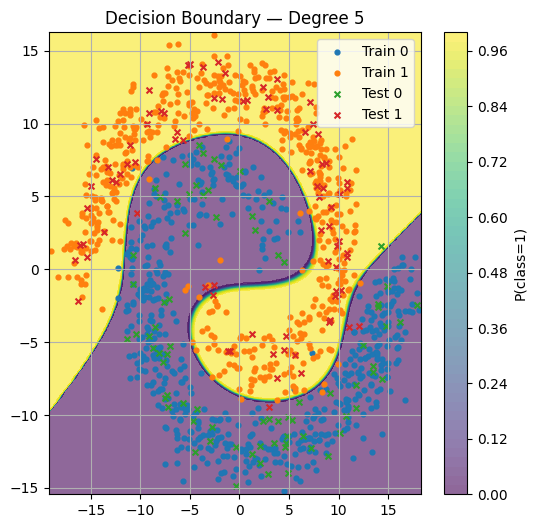

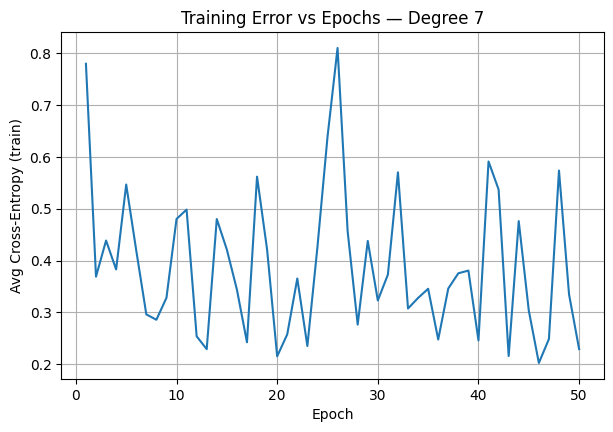


Degree 7 — Train Confusion Matrix:
[[567   5]
 [ 10 541]]
Train Accuracy: 98.66%

Degree 7 — Test Confusion Matrix:
[[77  1]
 [ 4 78]]
Test Accuracy: 96.88%


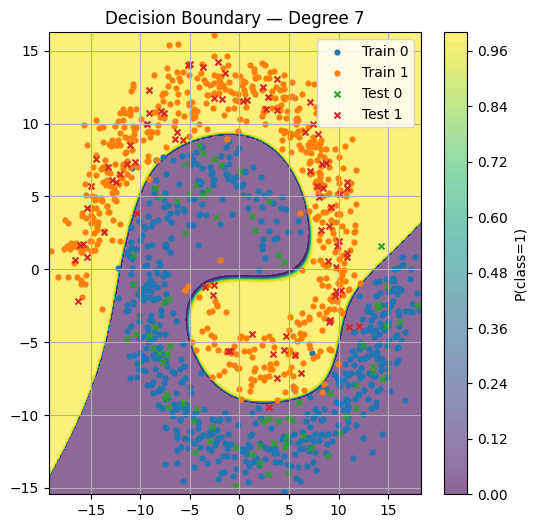

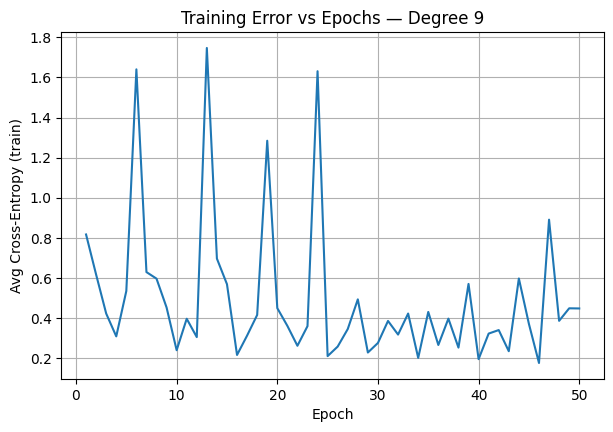


Degree 9 — Train Confusion Matrix:
[[546  26]
 [  4 547]]
Train Accuracy: 97.33%

Degree 9 — Test Confusion Matrix:
[[71  7]
 [ 2 80]]
Test Accuracy: 94.38%


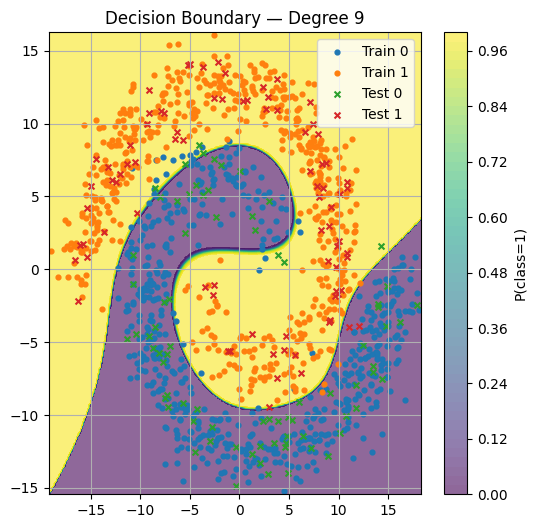

In [6]:
# Logistic Regression (SGD + Momentum) — Dataset 3
# Polynomial degrees: 5, 7, 9 | LR=0.7 | Momentum=0.9
# Plots loss curves, decision boundaries, confusion matrices & accuracies

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

DEGREES = [5, 7, 9]
ETA, MOMENTUM, TOL, MAX_EPOCHS = 0.7, 0.9, 1e-3, 50
TRAIN_PATHS = ["/mnt/data/train.csv", r"H:\Sem-7\CS5691\Assignment-3\Datasets\Dataset3\train.csv"]
TEST_PATHS  = ["/mnt/data/test.csv",  r"H:\Sem-7\CS5691\Assignment-3\Datasets\Dataset3\test.csv"]

sigmoid = lambda z: 1/(1+np.exp(-np.clip(z, -40, 40)))

def avg_loss(X, y, w):
    p = sigmoid(X @ w); eps = 1e-12
    return np.mean(-(y*np.log(p+eps)+(1-y)*np.log(1-p+eps)))

def train_sgd_momentum(X, y, deg):
    poly = PolynomialFeatures(deg, include_bias=False)
    scaler = StandardScaler()
    Xp = scaler.fit_transform(poly.fit_transform(X))
    Xp = np.c_[Xp, np.ones(len(Xp))]
    w, v, losses = np.zeros(Xp.shape[1]), np.zeros(Xp.shape[1]), []
    prev = None
    for _ in range(MAX_EPOCHS):
        for i in np.random.permutation(len(Xp)):
            p = sigmoid(Xp[i] @ w)
            v = MOMENTUM*v - ETA*(p - y[i])*Xp[i]
            w += v
        cur = avg_loss(Xp, y, w); losses.append(cur)
        if prev and abs(prev-cur) < TOL: break
        prev = cur
    return dict(w=w, poly=poly, scaler=scaler, losses=losses)

def predict(model, X):
    Xp = model["scaler"].transform(model["poly"].transform(X))
    Xp = np.c_[Xp, np.ones(len(Xp))]
    return (sigmoid(Xp @ model["w"]) >= 0.5).astype(int)

def plot_loss(losses, deg):
    plt.figure(figsize=(7,4.5))
    plt.plot(range(1,len(losses)+1), losses)
    plt.xlabel("Epoch"); plt.ylabel("Avg Cross-Entropy (train)")
    plt.title(f"Training Error vs Epochs — Degree {deg}")
    plt.grid(True); plt.show()

def plot_boundary(model, Xtr, ytr, Xte=None, yte=None, deg=None):
    if Xtr.shape[1] != 2: return
    x1, x2 = Xtr[:,0], Xtr[:,1]
    xx, yy = np.meshgrid(np.linspace(x1.min()-0.2, x1.max()+0.2, 300),
                         np.linspace(x2.min()-0.2, x2.max()+0.2, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Xg = model["scaler"].transform(model["poly"].transform(grid))
    Xg = np.c_[Xg, np.ones(len(Xg))]
    Z = sigmoid(Xg @ model["w"]).reshape(xx.shape)
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, levels=50, alpha=0.6)
    plt.colorbar(label="P(class=1)")
    plt.scatter(Xtr[ytr==0,0], Xtr[ytr==0,1], s=12, label="Train 0")
    plt.scatter(Xtr[ytr==1,0], Xtr[ytr==1,1], s=12, label="Train 1")
    if Xte is not None and yte is not None:
        plt.scatter(Xte[yte==0,0], Xte[yte==0,1], marker='x', s=18, label="Test 0")
        plt.scatter(Xte[yte==1,0], Xte[yte==1,1], marker='x', s=18, label="Test 1")
    plt.title(f"Decision Boundary — Degree {deg}")
    plt.legend(); plt.grid(True); plt.show()

def first_existing(paths):
    return next((p for p in paths if os.path.exists(p)), None)

train_path, test_path = first_existing(TRAIN_PATHS), first_existing(TEST_PATHS)
if not train_path:
    print("❗ train.csv not found. Upload it or edit TRAIN_PATHS.")
else:
    Xtr, ytr = pd.read_csv(train_path).to_numpy()[:,:-1], pd.read_csv(train_path).to_numpy()[:,-1].astype(int)
    Xte = yte = None
    if test_path:
        df_te = pd.read_csv(test_path)
        Xte, yte = df_te.iloc[:,:-1].to_numpy(float), df_te.iloc[:,-1].to_numpy(int)

    for deg in DEGREES:
        model = train_sgd_momentum(Xtr, ytr, deg)
        plot_loss(model["losses"], deg)

        for name, X, y in [("Train", Xtr, ytr), ("Test", Xte, yte)]:
            if X is None: continue
            ypred = predict(model, X)
            cm = confusion_matrix(y, ypred)
            acc = accuracy_score(y, ypred) * 100
            print(f"\nDegree {deg} — {name} Confusion Matrix:\n{cm}\n{name} Accuracy: {acc:.2f}%")

        plot_boundary(model, Xtr, ytr, Xte, yte, deg)
